In [1]:
# run this only if you are running in Google Colab and pull the library from Github
!git clone https://github.com/ipfloater/ML_misc.git

Cloning into 'ML_misc'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 130 (delta 73), reused 47 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (130/130), 861.25 KiB | 6.02 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# run this only if you are running in Google Colab and pull the library from Github\
import sys

sys.path = ['ML_misc/'] + sys.path

# Unit Test:
* Pipeline
* Ensemble estimators

In [3]:
import unittest
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from itertools import cycle
from plotnine import ggplot, aes, geom_line, labs, theme_bw, scale_color_manual, ggtitle
from sklearn_ML.ensemble_classifier import EnsembleClassifier
from sklearn_ML.pipeline_utils import PipelineBuilder

class TestPipelineAndEnsemble(unittest.TestCase):

    def setUp(self):
        # Create synthetic dataset
        n_samples = 1000
        X, y = make_classification(n_samples=n_samples, n_features=20, n_informative=15, n_redundant=5, random_state=42)
        weights = np.ones_like(y, dtype=float)
        X_all = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
        nn = n_samples*80//100
        X_train_w_cols = X_all.iloc[:nn]
        y_train = pd.Series(y[:nn])
        wt_train = pd.Series(weights[:nn])
        X_test_w_cols = X_all.iloc[nn:]
        y_test = pd.Series(y[nn:])
        wt_test = pd.Series(weights[nn:])

        self.model_data = (X_all, X_train_w_cols, y_train, wt_train, X_test_w_cols, y_test, wt_test)
        self.excl_model_cols = []
        self.bench_scores = []

    def test_pipeline_building(self):
        pipeline_lin, pipeline_nlin = PipelineBuilder.build_pipeline(self.model_data[0], self.excl_model_cols)
        self.assertIsNotNone(pipeline_lin, "Linear pipeline should not be None")
        self.assertIsNotNone(pipeline_nlin, "Non-linear pipeline should not be None")

    def test_ensemble_classifier_run(self):
        ensemble = EnsembleClassifier(self.model_data, self.excl_model_cols, self.bench_scores)
        result = ensemble.run(include_stacking=True, perform_cv=False, list_of_estimators=['Logi', 'RandomForest', 'HistGradientBoosting', 'AdaBoosting', 'Bagging'])
        self.assertIsInstance(result, pd.DataFrame, "The result should be a DataFrame")
        self.assertFalse(result.empty, "The result DataFrame should not be empty")

    def test_classifier_estimators_building(self):
        pipeline_lin, pipeline_nlin = PipelineBuilder.build_pipeline(self.model_data[0], self.excl_model_cols)
        ensemble = EnsembleClassifier(self.model_data, self.excl_model_cols, self.bench_scores)
        estimators, stacking_clf = ensemble.build_classifier_estimators(pipeline_lin, pipeline_nlin)
        self.assertTrue(len(estimators) > 0, "There should be at least one estimator")
        self.assertIsNotNone(stacking_clf, "Stacking classifier should not be None")

unittest.main(argv=[''], verbosity=2, exit=False)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

test_classifier_estimators_building (__main__.TestPipelineAndEnsemble) ... ok
test_ensemble_classifier_run (__main__.TestPipelineAndEnsemble) ... 

INFO: building classfier based on list_of_estimators = []
INFO: ensemble estimator RandomForest
INFO: building classfier based on list_of_estimators = ['Logi', 'RandomForest', 'HistGradientBoosting', 'AdaBoosting', 'Bagging']
INFO: ensemble estimator RandomForest


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarn

# Unit Tests:
* PartialDependencyPlot
* ROC_AUC curve
* Precision_Recall curve

test_partial_dependence_display (__main__.TestPipelineAndEnsemble) ... 

INFO: building classfier based on list_of_estimators = ['Logi', 'RandomForest', 'HistGradientBoosting', 'AdaBoosting', 'Bagging']
INFO: ensemble estimator RandomForest


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarn

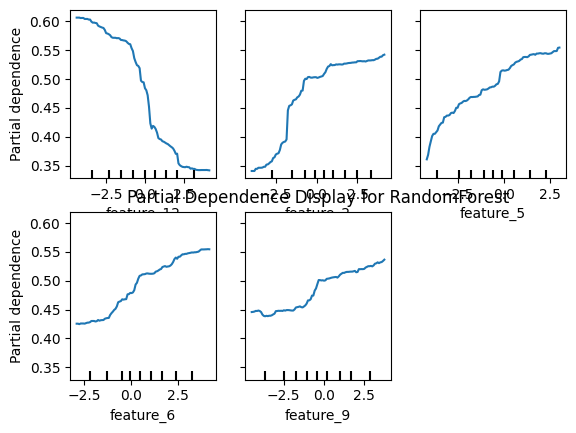

ok
test_roc_auc_and_precision_recall_curve (__main__.TestPipelineAndEnsemble) ... 

INFO: building classfier based on list_of_estimators = ['Logi', 'RandomForest', 'HistGradientBoosting', 'AdaBoosting', 'Bagging']
INFO: ensemble estimator RandomForest


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarn

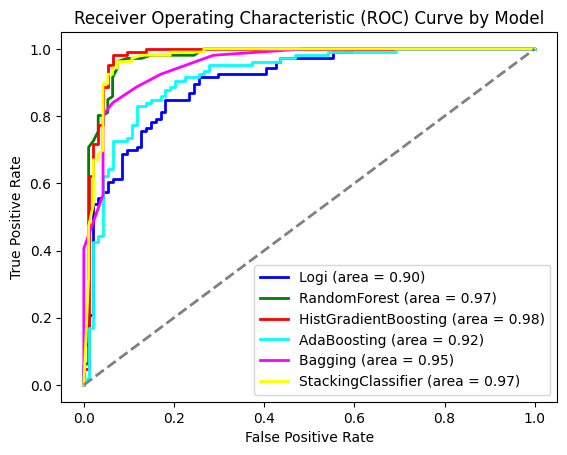

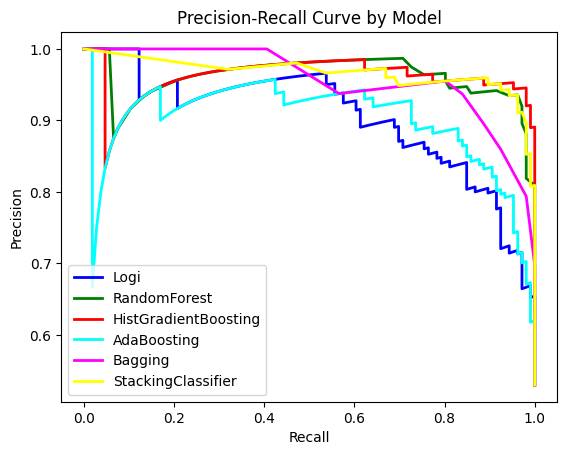

ok
test_roc_auc_and_precision_recall_curve_plotnine (__main__.TestPipelineAndEnsemble) ... 

INFO: building classfier based on list_of_estimators = ['Logi', 'RandomForest', 'HistGradientBoosting', 'AdaBoosting', 'Bagging']
INFO: ensemble estimator RandomForest


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarn

<ggplot: (640 x 480)>
<ggplot: (640 x 480)>


In [4]:
import unittest
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
from itertools import cycle
from plotnine import ggplot, aes, geom_line, labs, theme_bw, scale_color_manual, ggtitle
from sklearn_ML.ensemble_classifier import EnsembleClassifier
from sklearn_ML.pipeline_utils import PipelineBuilder

class TestPipelineAndEnsemble(unittest.TestCase):

    def setUp(self):
        # Create synthetic dataset
        n_samples = 1000
        X, y = make_classification(n_samples=n_samples, n_features=20, n_informative=15, n_redundant=5, random_state=42)
        weights = np.ones_like(y, dtype=float)
        X_all = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
        nn = n_samples*80//100
        X_train_w_cols = X_all.iloc[:nn]
        y_train = pd.Series(y[:nn])
        wt_train = pd.Series(weights[:nn])
        X_test_w_cols = X_all.iloc[nn:]
        y_test = pd.Series(y[nn:])
        wt_test = pd.Series(weights[nn:])

        self.model_data = (X_all, X_train_w_cols, y_train, wt_train, X_test_w_cols, y_test, wt_test)
        self.excl_model_cols = []
        self.bench_scores = []
        # Run the ensemble classifier
        self.ensemble = EnsembleClassifier(self.model_data, self.excl_model_cols, self.bench_scores)
        self.result = self.ensemble.run(include_stacking=True, perform_cv=False, list_of_estimators=['Logi', 'RandomForest', 'HistGradientBoosting', 'AdaBoosting', 'Bagging'])

    def test_roc_auc_and_precision_recall_curve(self):

        # Filter results for test set predictions
        test_results = self.result.query(f'type == "test"')

        # Colors for plotting
        colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])

        # Plot ROC AUC curve for each model using matplotlib
        plt.figure()
        for model_name in test_results['model'].unique():
            model_results = test_results.query(f'model == "{model_name}"')
            y_test = model_results['actual']
            y_pred = model_results['pred']
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)
            color = next(colors)
            plt.plot(fpr, tpr, color=color, lw=2, label=f'{model_name} (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve by Model')
        plt.legend(loc='lower right')
        plt.show()

        # Plot Precision-Recall curve for each model using matplotlib
        plt.figure()
        colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])
        for model_name in test_results['model'].unique():
            model_results = test_results.query(f'model == "{model_name}"')
            y_test = model_results['actual']
            y_pred = model_results['pred']
            precision, recall, _ = precision_recall_curve(y_test, y_pred)
            color = next(colors)
            plt.plot(recall, precision, color=color, lw=2, label=f'{model_name}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve by Model')
        plt.legend(loc='lower left')
        plt.show()

    def test_roc_auc_and_precision_recall_curve_plotnine(self):
        # Filter results for test set predictions
        test_results = self.result.query(f'type == "test"')

        # Prepare data for ROC AUC curve with plotnine
        roc_data = []
        for model_name in test_results['model'].unique():
            model_results = test_results.query(f'model == "{model_name}"')
            y_test = model_results['actual']
            y_pred = model_results['pred']
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            roc_data.append(pd.DataFrame({
                'fpr': fpr,
                'tpr': tpr,
                'model': model_name
            }))
        roc_df = pd.concat(roc_data, axis=0)

        # Plot ROC AUC curve using plotnine
        roc_plot = (
            ggplot(roc_df, aes(x='fpr', y='tpr', color='model')) +
            geom_line() +
            labs(x='False Positive Rate', y='True Positive Rate', title='Receiver Operating Characteristic (ROC) Curve by Model') +
            theme_bw() +
            scale_color_manual(values=['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])
        )
        print(roc_plot)

        # Prepare data for Precision-Recall curve with plotnine
        pr_data = []
        for model_name in test_results['model'].unique():
            model_results = test_results.query(f'model == "{model_name}"')
            y_test = model_results['actual']
            y_pred = model_results['pred']
            precision, recall, _ = precision_recall_curve(y_test, y_pred)
            pr_data.append(pd.DataFrame({
                'recall': recall,
                'precision': precision,
                'model': model_name
            }))
        pr_df = pd.concat(pr_data, axis=0)

        # Plot Precision-Recall curve using plotnine
        pr_plot = (
            ggplot(pr_df, aes(x='recall', y='precision', color='model')) +
            geom_line() +
            labs(x='Recall', y='Precision', title='Precision-Recall Curve by Model') +
            theme_bw() +
            scale_color_manual(values=['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])
        )
        print(pr_plot)

    def test_partial_dependence_display(self, model_name='RandomForest'):
        estimators = self.ensemble.estimators

        # Use the first estimator for partial dependence display
        if estimators:
            for mod_name, estimator in estimators:
                if mod_name != model_name:
                    continue
                # features = [0, 1]
                # Choosing top 5 features for partial dependence
                if not hasattr(estimator[1], 'feature_importances_'):
                    print(f'WARNING: feature_importances_ not available for {model_name}, skipping')
                    break

                features = np.argsort(estimator[1].feature_importances_)[-5:][::-1]
                PartialDependenceDisplay.from_estimator(estimator, self.model_data[1], features)
                plt.title(f'Partial Dependence Display for {mod_name}')
                plt.show()


unittest.main(argv=[''], verbosity=2, exit=False)